In [ ]:
#part 1

In [1]:
import geopandas as gpd
import contextily as ctx # for basemaps
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import folium

In [2]:
!pip install fiona

## Reading in Vector data
For this lesson we are using data in the ESRI [Shapefile](https://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm) format. 

Geopandas supports reading a number of different GIS vector file formats: https://geopandas.org/en/stable/docs/user_guide/io.html

Geopandas uses [fiona](https://fiona.readthedocs.io/en/stable/fiona.html) to handle reading and writing vector file types.

In [3]:
# print out the supported file types
import fiona; fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

We will first look at some flood risk assessment data from the Philippines. This data is originally from the Humanitarian Data Exchange: https://data.humdata.org/dataset/wfp-geonode-ica-philippines-flood-risk

It is currently stored in this folder as a .zip, which we will unzip using the command-line `unzip` command with the argument `-d` to provide a destination folder name for the unzipped files.

In [4]:
#should only be ran once
#!unzip phl_ica_floodrisk_geonode_mar2014.zip -d philippines_flood_risk

In [5]:
# path to shapefile
filepath = "philippines_flood_risk/phl_ica_floodrisk_geonode_mar2014.shp"

# Read file using gpd.read_file()
data = gpd.read_file(filepath)

In [6]:
data.head() #look at top entries - looks like a pandas dataframe

,iso3,adm0_name,adm1_name,adm2_name,AvgFLRisk,FloodClass,FloodText,geometry
0,PHL,Philippines,Region XIII,Surigao del Sur,1.26059,4,Very High,"MULTIPOLYGON (((126.4175 7.96417, 126.41778 7...."
1,PHL,Philippines,Region III,Tarlac,1.84024,2,Medium,"POLYGON ((120.63007 15.73335, 120.63052 15.729..."
2,PHL,Philippines,Autonomous region in Muslim Mindanao,Tawi-Tawi,3.00000,1,Low,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
3,PHL,Philippines,Region III,Zambales,1.84305,2,Medium,"MULTIPOLYGON (((120.08285 14.75048, 120.08222 ..."
4,PHL,Philippines,Region VIII,Zamboanga del Norte,2.01604,2,Medium,"MULTIPOLYGON (((122.09467 7.53152, 122.09467 7..."


In [7]:
data.columns

Index(['iso3', 'adm0_name', 'adm1_name', 'adm2_name', 'AvgFLRisk',
       'FloodClass', 'FloodText', 'geometry'],
      dtype='object')

In [8]:
data['FloodText'].value_counts()

FloodText
Very High        20
Medium           20
Low              20
High             20
Uncategorized     2
Name: count, dtype: int64

In [9]:
# Note the column 'geometry' is full of shapely Polygon objects
type(data['geometry'].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

Note that the data are in (lon, lat) ordering --- this is because the convention is (x, y) for computers, but (lat, lon) for coordinates. This is a frequent cause of error.

In [10]:
data['geometry']

0     MULTIPOLYGON (((126.4175 7.96417, 126.41778 7....
1     POLYGON ((120.63007 15.73335, 120.63052 15.729...
2     MULTIPOLYGON (((119.46694 4.58694, 119.46639 4...
3     MULTIPOLYGON (((120.08285 14.75048, 120.08222 ...
4     MULTIPOLYGON (((122.09467 7.53152, 122.09467 7...
                            ...                        
77    MULTIPOLYGON (((121.43574 12.20257, 121.43555 ...
78    MULTIPOLYGON (((117.31389 7.51417, 117.31416 7...
79    MULTIPOLYGON (((120.61667 14.8, 120.61584 14.8...
80    MULTIPOLYGON (((119.86505 15.8117, 119.86479 1...
81    MULTIPOLYGON (((125.22166 10.43444, 125.22195 ...
Name: geometry, Length: 82, dtype: geometry

In [11]:
# geopandas adds useful attributes to the geodataframe, such as the ability to get bounds
# of all the geometry data
data.bounds #smallest bounding rectangle for each polygon.

,minx,miny,maxx,maxy
0,125.743440,7.90974,126.459720,9.495150
1,120.163240,15.16303,120.782870,15.889110
2,118.082343,4.58694,120.684193,7.959167
3,119.785450,14.73778,120.460620,15.845260
4,121.901390,7.14597,123.555260,8.859560
...,...,...,...,...
77,120.797230,12.19500,121.558040,13.531390
78,116.928340,7.50694,121.335205,12.669720
79,120.358330,14.76695,120.987070,15.280140
80,119.749440,15.61848,120.922330,16.443890


In [12]:
# similary, we can get attributes such as boundary
data.boundary

0     MULTILINESTRING ((126.4175 7.96417, 126.41778 ...
1     LINESTRING (120.63007 15.73335, 120.63052 15.7...
2     MULTILINESTRING ((119.46694 4.58694, 119.46639...
3     MULTILINESTRING ((120.08285 14.75048, 120.0822...
4     MULTILINESTRING ((122.09467 7.53152, 122.09467...
                            ...                        
77    MULTILINESTRING ((121.43574 12.20257, 121.4355...
78    MULTILINESTRING ((117.31389 7.51417, 117.31416...
79    MULTILINESTRING ((120.61667 14.8, 120.61584 14...
80    MULTILINESTRING ((119.86505 15.8117, 119.86479...
81    MULTILINESTRING ((125.22166 10.43444, 125.2219...
Length: 82, dtype: geometry

## Coordinate reference systems

There are many different coordinate reference systems (CRS), which refer to different ways of indicating where on the earth you are referring to when you give a coordinate. Different CRS use different models of the earth's surface, map projections, units, and origin points (where 0,0 is). The discussion of the specifics is beyond the scope of this course. 

For the purposes of this course, we will primarily use the two following:

### WGS 84: https://epsg.io/4326
```
The CRS used by the GPS system
units: degrees
0,0 is the intersection of greenwich meridian and equator
epsg code: 4326
```

### Web Mercator: https://epsg.io/3857
```
The CRS used by most web maps, such as Google maps, OSM, Bing, etc.
Not accurate at high latitudes >85 degrees, <-85 degrees
units: meters
0,0 is intersection of greensich meridian and equator
epsg code: 3857
```


In [13]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# area will warn you if you're trying to do area calculations in geographic CRS
data.area #since degrees near the equator are different then degrees near the poles, so area isn't consistent, as Earth is an ellipse.

/tmp/ipykernel_6934/1134334699.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data.area #since degrees near the equator are different then degrees near the poles, so area isn't consistent, as Earth is an ellipse.


0     0.354086
1     0.253924
2     0.096272
3     0.307649
4     0.524341
        ...   
77    0.353264
78    1.198929
79    0.189129
80    0.438444
81    0.699996
Length: 82, dtype: float64

In [15]:
data_in_3857 = data.to_crs('epsg:3857')
data_in_3857.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
data_in_3857.area

0     4.440462e+09
1     3.265073e+09
2     1.198108e+09
3     3.952322e+09
4     6.562483e+09
          ...     
77    4.492212e+09
78    1.508870e+10
79    2.427019e+09
80    5.652195e+09
81    8.946676e+09
Length: 82, dtype: float64

# Exercise
Find an interesting GIS dataset and:
- visualize some raw data
- ask an interesting analysis question about it:
  - intersections, sizes, quantities
  - relationships
  - e.g. which latitudes contain the most endangered species? what countries have the most ports per km of coastline?
- Visualize some of your analysis
You can use the location you've chosen for your location fan-cam as a place of interest! 

Note that since geopandas is built on pandas, all of your knowledge from pandas should also carry over!

As per usual, we'll ask a few volunteers to present their results.

Here are some resources to look for GIS datasets:
- Cambridge, MA GIS data: http://cambridgegis.github.io/gisdata.html
- Awesome GIS data: https://github.com/sshuair/awesome-gis#data
- Humanitarian Data Exchange: https://data.humdata.org/
- Data.gov: https://www.data.gov/
Search for GeoJSON and/or Shapefile file types.

One tool to help draw GIS polygons is https://geojson.io; you can export your polygon as a geojson and upload it to your jupyter instance to access from jupyter.

In [53]:
#!unzip TRAFFIC_SpeedStudies.shp.zip -d speed_studies

In [54]:
# path to shapefile
filepath = "speed_studies/TRAFFIC_SpeedStudies.shp"

# Read file using gpd.read_file()
speed_data = gpd.read_file(filepath)

In [55]:
speed_data.head()

,DATE,STREET,CROSSING_S,DIRECTION,SPEED_85TH,XCoord,YCoord,Limit,geometry
0,2004/09/22,Aberdeen Ave.,Library,NB,36.0,-71.145988,42.375643,U,POINT (751822.888 2962109.367)
1,2004/09/21,Aberdeen Ave.,Library,SB,36.0,-71.145988,42.375643,U,POINT (751822.888 2962109.367)
2,2003/11/18,Aberdeen Ave.,Library,NB,37.0,-71.145988,42.375643,U,POINT (751822.888 2962109.367)
3,2003/11/19,Aberdeen Ave.,Library,SB,36.0,-71.145988,42.375643,U,POINT (751822.888 2962109.367)
4,2002/01/16,Alpine Street,44,SB,32.0,-71.138261,42.384026,25,POINT (753897.938 2965173.096)


In [56]:
speed_data.columns

Index(['DATE', 'STREET', 'CROSSING_S', 'DIRECTION', 'SPEED_85TH', 'XCoord',
       'YCoord', 'Limit', 'geometry'],
      dtype='object')

In [57]:
speed_data['SPEED_85TH'].value_counts()

SPEED_85TH
30.0    84
29.0    78
28.0    63
31.0    58
27.0    49
26.0    44
25.0    36
33.0    33
32.0    33
34.0    25
24.0    24
23.0    22
35.0    20
22.0    19
37.0    15
36.0    14
20.0    13
38.0     7
39.0     6
21.0     5
40.0     4
19.0     3
0.0      2
41.0     1
17.0     1
16.0     1
14.0     1
18.0     1
Name: count, dtype: int64

In [58]:
speed_data['Limit'].value_counts()

Limit
U     526
25    134
30      2
Name: count, dtype: int64

In [59]:
#According to the docs, 'U' means a speed limit wasn't found. This is confusing.

speed_data.loc[speed_data['Limit'] == 'U', 'Limit'] = 'Not Found'
speed_data['Limit'].value_counts()

Limit
Not Found    526
25           134
30             2
Name: count, dtype: int64

In [60]:
speed_data.crs

<Projected CRS: PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEO ...>
Name: NAD83 / Massachusetts Mainland (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [61]:
speed_data_in_3857 = speed_data.to_crs('epsg:3857')
speed_data_in_3857.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

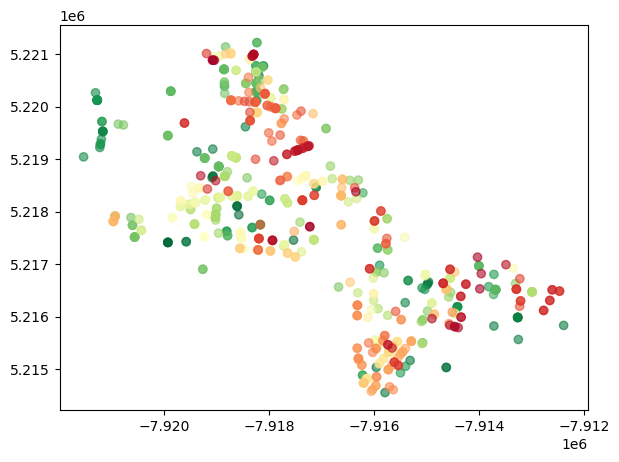

In [62]:
speed_data_in_3857.plot(figsize=(10,5), alpha=0.6, cmap='RdYlGn_r')

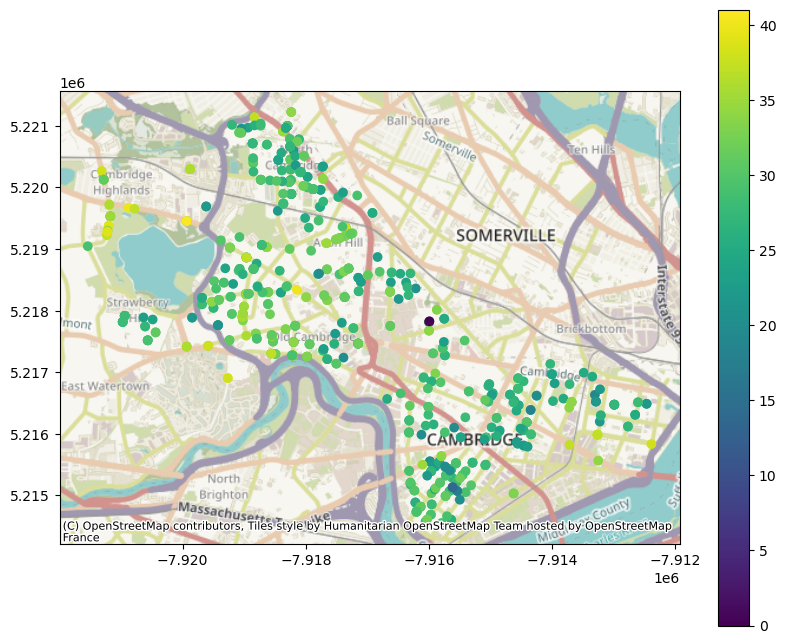

In [63]:
ax = speed_data_in_3857.plot(figsize=(10,8), column='SPEED_85TH', legend=True)
# now we add a basemap. ctx finds a basemap for a background from
# an online repository.
# It assumes the data is in web mercator (epsg:3857) unless you specify otherwise
ctx.add_basemap(ax, crs=speed_data_in_3857.crs)

In [64]:
speed_data_in_3857.explore("SPEED_85TH",cmap='RdYlGn_r')

In [251]:
m_speed = speed_data_in_3857.explore('SPEED_85TH',titles=xyz.CartoDB.Voyager,name='Average Speed')

# add a layer control menu
folium.LayerControl().add_to(m_speed)
m_speed

In [66]:
"""
Great. Now to look at the cool stuff, the ratio between the speed limit and the average speed.
I did a research project in which I created multiple AI models to automatically detect parking spaces and
the occupancy status of those spaces. My goal was not only to make it more convenient to find parking but also 
to reduce emissions, as I had found that drivers looking for parking created more traffic and therefore 
excess emissions(30% of all road vehicle emissions come from drivers trying to find parking). Lets see if 
that checks out in this data by merging this ratio data with the other parking dataset.
"""

'\nGreat. Now to look at the cool stuff, the ratio between the speed limit and the average speed.\nI did a research project in which I created multiple AI models to automatically detect parking spaces and\nthe occupancy status of those spaces. My goal was not only to make it more convenient to find parking but also \nto reduce emissions, as I had found that drivers looking for parking created more traffic and therefore \nexcess emissions(30% of all road vehicle emissions come from drivers trying to find parking). Lets see if \nthat checks out in this data by merging this ratio data with the other parking dataset.\n'

In [70]:
#first, creating a ratio column.
import pandas as pd
speed_data_ratio = speed_data.query("Limit != 'Not Found'").copy()

speed_data_ratio['ratio'] = speed_data_ratio['SPEED_85TH']/speed_data_ratio['Limit'].apply(pd.to_numeric)

In [71]:
speed_data_ratio.head()

,DATE,STREET,CROSSING_S,DIRECTION,SPEED_85TH,XCoord,YCoord,Limit,geometry,ratio
4,2002/01/16,Alpine Street,44,SB,32.0,-71.138261,42.384026,25,POINT (753897.938 2965173.096),1.28
12,1999/07/08,Alpine Street,50,SB,29.0,-71.138419,42.383832,25,POINT (753855.438 2965101.876),1.16
13,1999/06/01,Alpine Street,Concord Ave,SB,28.0,-71.137280,42.385250,25,POINT (754161.128 2965620.066),1.12
14,1999/07/07,Alpine Street,44,SB,28.0,-71.138261,42.384026,25,POINT (753897.938 2965173.096),1.12
20,2006/06/14,Brookline Street,Chestnut Street,NB,29.0,-71.108802,42.356637,25,POINT (761902.566 2955227.008),1.16


In [176]:
speed_data_ratio_in_3857 = speed_data_ratio.to_crs('epsg:3857')

In [255]:
m_ratio = speed_data_ratio.explore('ratio',name='Ratio',cmap='RdYlGn')
m_ratio

# Adding parking data to map

In [81]:
#Using cambrage GIS traffic data
#!unzip TRAFFIC_CommercialParking.shp.zip -d parking_traffic

In [82]:
# path to shapefile
filepath = "parking_traffic/TRAFFIC_CommercialParking.shp"

# Read file using gpd.read_file()
parking_data = gpd.read_file(filepath)

In [83]:
parking_data.head()

,Id,DESCRIPTIO,ML,ADDRESS,ACCESSVIA,STRUCTURE,OWNTYPE,TOTALSP,GlobalID,COMMSPAC,geometry
0,0,Cambridge Hospital Garage,111-56,1493 Cambridge Street,Cambridge Street,Garage,Private,310.0,{8E9EB9DB-CB89-49BF-A695-44070573C3F4},150,POINT (763006.354 2961968.034)
1,0,1 Kendall Square Garage,39-174,389 Binney Street / 205 B,Broadway,Garage,Private,1566.0,{52577D0A-3EC5-43EE-9E33-A6D07AA60865},1050,POINT (767098.905 2959389.338)
2,0,Municipal Lot #11,80-142,984 Cambridge Street,Cambridge or Windsor,Lot,Municipal,15.0,{9D198A10-7263-449A-80FF-E67EFB733866},15,POINT (765922.44 2961030.44)
3,0,Monitor Building Public Garage,8-75,2 Canal Park,Monsignor O'Brien Highway,Garage,Private,177.0,{3DF631A0-7A9F-4034-934C-ED436DB501A9},50,POINT (770597.934 2960248.529)
4,0,Cambridgeside Galleria,8-1,78-90 First Street,Lower: Land Blvd. Camb,Garage,Private,2538.0,{B6E34E88-4654-4219-B825-5330E9C2F96C},2538,POINT (770514.411 2959506.347)


In [84]:
parking_data.columns

Index(['Id', 'DESCRIPTIO', 'ML', 'ADDRESS', 'ACCESSVIA', 'STRUCTURE',
       'OWNTYPE', 'TOTALSP', 'GlobalID', 'COMMSPAC', 'geometry'],
      dtype='object')

In [138]:
parking_data.crs

<Projected CRS: PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEO ...>
Name: NAD83 / Massachusetts Mainland (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [139]:
parking_data_in_3857 = parking_data.to_crs('epsg:3857')

In [140]:
parking_data_in_3857['TOTALSP'].min(),parking_data_in_3857['TOTALSP'].max()

(8.0, 2733.0)

In [141]:
m_ratio = parking_data_in_3857[['DESCRIPTIO','STRUCTURE','OWNTYPE','TOTALSP','COMMSPAC','geometry']]\
                        .explore('TOTALSP',name='Total Parking Spaces',cmap='RdYlGn_r',m=m_ratio,marker_type='circle',marker_kwds={'radius':200})

folium.LayerControl().add_to(m_ratio)
m_ratio                      

In [195]:
speed_min,speed_max = speed_data_ratio_in_3857['ratio'].min(), speed_data_ratio_in_3857['ratio'].max()
speed_median = speed_data_ratio_in_3857['ratio'].median()
speed_min,speed_max,speed_median

(0.8, 1.56, 1.2)

In [196]:
park_min,park_max = parking_data_in_3857['TOTALSP'].min(), parking_data_in_3857['TOTALSP'].max()
park_median = parking_data_in_3857['TOTALSP'].median()
park_min,park_max,park_median

(8.0, 2733.0, 180.0)

In [187]:
print(len(parking_data_in_3857))

39


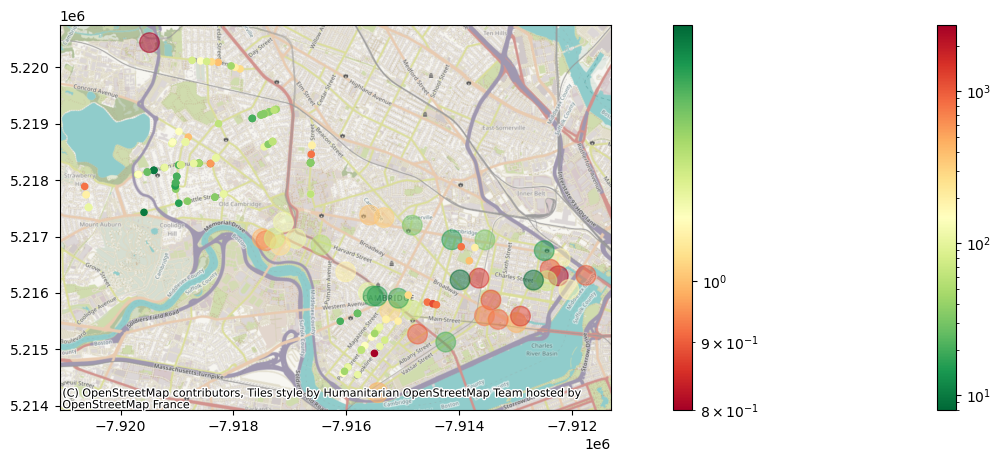

In [265]:
import matplotlib.colors as colors

parking_cmap_norm = colors.LogNorm(vmin=park_min, vmax=park_max)#colors.CenteredNorm(vcenter=180)#colors.Normalize(vmin=0.8,vmax=1.56)
speed_cmap_norm = colors.LogNorm(vmin=speed_min,vmax=speed_max)#colors.CenteredNorm(vcenter=1)

ax = parking_data_in_3857.plot('TOTALSP',figsize=(20,5),cmap='RdYlGn_r',norm=parking_cmap_norm,legend=True,alpha=0.5,markersize=200)
speed_data_ratio_in_3857.plot('ratio',cmap='RdYlGn',norm=speed_cmap_norm,legend=True,ax=ax,markersize=20)

xmin,ymin,xmax,ymax = parking_data_in_3857.bounds

ctx.add_basemap(ax, crs=parking_data_in_3857.crs)

In [204]:
park_min,park_max = parking_data_in_3857['COMMSPAC'].min(), parking_data_in_3857['COMMSPAC'].max()
park_median = parking_data_in_3857['COMMSPAC'].median()
park_min,park_max,park_median

(8, 2733, 109.0)

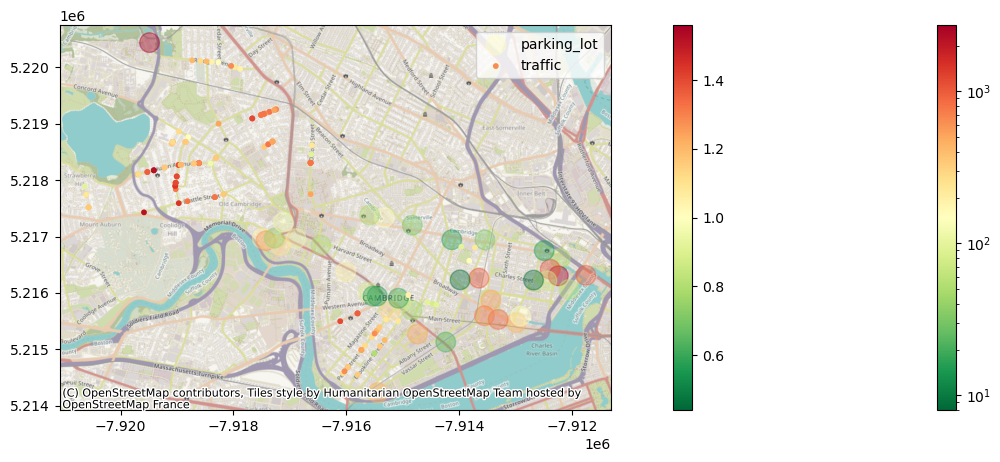

In [254]:
parking_cmap_norm = colors.LogNorm(vmin=park_min, vmax=park_max)#colors.CenteredNorm(vcenter=180)#colors.Normalize(vmin=0.8,vmax=1.56)

ax = parking_data_in_3857.plot('COMMSPAC',figsize=(20,5),cmap='RdYlGn_r',norm=parking_cmap_norm,legend=True,alpha=0.4,markersize=200)
speed_data_ratio_in_3857.plot('ratio',cmap='RdYlGn_r',norm=speed_cmap_norm,legend=True,ax=ax,markersize=10)

xmin,ymin,xmax,ymax = parking_data_in_3857.bounds
ax.legend(['parking_lot','traffic'])

ctx.add_basemap(ax, crs=parking_data_in_3857.crs)

Best form of transportation in Cambridge

In [210]:
"""
!unzip TRANS_Rail.shp.zip -d rail_lines
!unzip TRANS_MajorRoads.shp.zip -d major_roads
!unzip TRANS_SubwayLines.shp.zip -d subway_lines
!unzip TRANS_SubwayStations.shp.zip -d subway_stations
"""

Archive:  TRANS_Rail.shp.zip
caution: filename not matched:  -rail_lines
Archive:  TRANS_MajorRoads.shp.zip
 extracting: major_roads/TRANS_MajorRoads.cpg  
  inflating: major_roads/TRANS_MajorRoads.dbf  
  inflating: major_roads/TRANS_MajorRoads.prj  
  inflating: major_roads/TRANS_MajorRoads.shp  
  inflating: major_roads/TRANS_MajorRoads.shp.xml  
  inflating: major_roads/TRANS_MajorRoads.shx  
Archive:  TRANS_SubwayLines.shp.zip
 extracting: subway_lines/TRANS_SubwayLines.cpg  
  inflating: subway_lines/TRANS_SubwayLines.dbf  
  inflating: subway_lines/TRANS_SubwayLines.prj  
  inflating: subway_lines/TRANS_SubwayLines.sbn  
  inflating: subway_lines/TRANS_SubwayLines.sbx  
  inflating: subway_lines/TRANS_SubwayLines.shp  
  inflating: subway_lines/TRANS_SubwayLines.shp.xml  
  inflating: subway_lines/TRANS_SubwayLines.shx  
Archive:  TRANS_SubwayStations.shp.zip
 extracting: subway_stations/TRANS_SubwayStations.cpg  
  inflating: subway_stations/TRANS_SubwayStations.dbf  
  inflati

In [214]:
data_train = gpd.read_file("rail_lines/TRANS_Rail.shp").to_crs('epsg:3857')
data_road = gpd.read_file("major_roads/TRANS_MajorRoads.shp").to_crs('epsg:3857')
data_subway = gpd.read_file("subway_lines/TRANS_SubwayLines.shp").to_crs('epsg:3857')
data_subway_stations = gpd.read_file("subway_stations/TRANS_SubwayStations.shp").to_crs('epsg:3857')

In [215]:
data_train.head()

,TYPE,GRADE,Shape_len,geometry
0,RAIL-ACTIVE,At-Grade,658.409088,"LINESTRING Z (-7919498.438 5219940.372 7.777, ..."
1,RAIL-ACTIVE,At-Grade,510.529579,"LINESTRING Z (-7919558.707 5219952.391 7.055, ..."
2,RAIL-ABANDON,At-Grade,2574.119927,"LINESTRING Z (-7919458.485 5219123.647 0, -791..."
3,RAIL-ACTIVE,At-Grade,344.430279,"LINESTRING Z (-7919626.319 5219966.061 7.055, ..."
4,RAIL-ABANDON,At-Grade,147.298450,"LINESTRING Z (-7919265.03 5219560.978 6.075, -..."


In [216]:
data_road.head()

,STREET,ST_NAME,ST_TYPE,MAJORROAD,Shape_len,geometry
0,Massachusetts Ave,Massachusetts,Ave,1,208.462056,"LINESTRING (-7918086.97 5220579.964, -7918097...."
1,Massachusetts Ave,Massachusetts,Ave,1,216.402201,"LINESTRING (-7918030.004 5220511.094, -7918038..."
2,Massachusetts Ave,Massachusetts,Ave,1,70.510148,"LINESTRING (-7918011.441 5220488.656, -7918020..."
3,Massachusetts Ave,Massachusetts,Ave,1,172.602341,"LINESTRING (-7917965.794 5220433.903, -7917977..."
4,Massachusetts Ave,Massachusetts,Ave,1,158.465451,"LINESTRING (-7917923.96 5220383.571, -7917933...."


In [217]:
data_subway.head()

,SOURCE,LINE,GRADE,GlobalID,created_us,created_da,last_edite,last_edi_1,SHAPE_len,geometry
0,CTPS,RED,7,{F085C350-175C-4DEF-95E0-449BABBB0EA4},None,0000/00/00,None,0000/00/00,25487.623970,"LINESTRING (-7912837.936 5215366.266, -7913047..."
1,CTPS,RED,4,{F7A58797-2EE6-41C3-B9F4-17E7E3D015AE},None,0000/00/00,None,0000/00/00,3587.266084,"LINESTRING (-7911391.176 5215152.096, -7911405..."
2,DLG,GREEN,4,{1455D796-D9BC-43F5-9140-FFA84F867C1B},None,0000/00/00,JAMERO,2022/02/09,11816.787685,"MULTILINESTRING ((-7910248.847 5215705.173, -7..."


In [218]:
data_subway_stations.head()

,STATION,LINE,created_us,created_da,last_edite,last_edi_1,GlobalID,geometry
0,DAVIS,RED,None,0000/00/00,None,0000/00/00,{715AA3BA-8657-49D6-9FD3-4BD0F13AB646},POINT (-7917311.773 5220597.581)
1,ALEWIFE,RED,None,0000/00/00,None,0000/00/00,{7D659127-8AE4-4B28-8F2A-7FB1641D85E6},POINT (-7919444.487 5220585.944)
2,PORTER,RED,None,0000/00/00,None,0000/00/00,{0E766FA3-07B1-4DED-8B2B-F9A358459BC0},POINT (-7916944.213 5219292.048)
3,HARVARD,RED,None,0000/00/00,None,0000/00/00,{0D956DEE-4EAC-4ED3-92FA-0FB3CF4AAED4},POINT (-7916931.882 5217090.022)
4,SCIENCE PARK,GREEN,None,0000/00/00,None,0000/00/00,{E550D5A3-00F1-4187-89DC-99E02D44B9BE},POINT (-7911235.971 5216085.125)


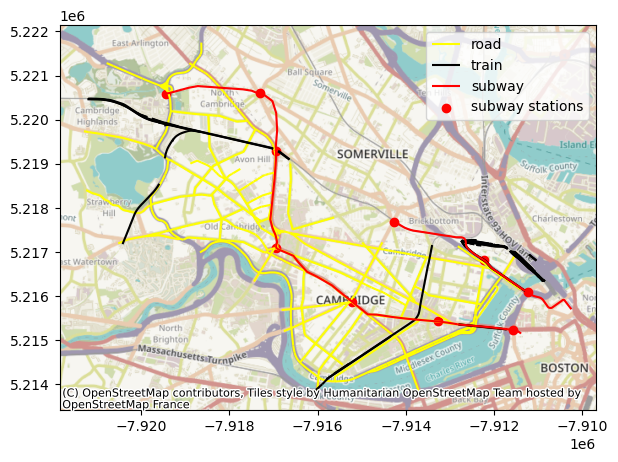

In [253]:
ax = data_road.plot(figsize=(20,5),color='yellow')
data_train.plot(ax=ax,color='black')
data_subway.plot(ax=ax,color='red')
data_subway_stations.plot(ax=ax,color='red')

ax.legend(['road', 'train', 'subway', 'subway stations'])

ctx.add_basemap(ax, crs=data_road.crs)

In [271]:
from matplotlib import colormaps
def parkColormap():
    return colormaps['RdYlGn_r']

In [272]:
m = parking_data_in_3857[['DESCRIPTIO','STRUCTURE','OWNTYPE','TOTALSP','COMMSPAC','geometry']]\
                        .explore('TOTALSP',name='Total Parking Spaces',cmap=parkColormap(),marker_type='circle',marker_kwds={'radius':200})

folium.LayerControl().add_to(m)
m

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'